# cs7324 Lab 6 - Convolutional Neural Networks

#### Chip Henderson - 48996654 

I've decided to use a brain tumor classification dataset from Kaggle for this lab. I've been interested in how AI is used in the medical industry, especially the field of radiology to identify and classify tumors from various types of scans. This was an opportunity to learn more about how this is done with machine learning models in the industry and to attempt to make my own version to see how it compared.

The data is comprised of MRI scans of patients falling into one of 4 categories of healthy or 3 classifications of brain tumors.
Dataset Source:
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/code

## Preparation

In [1]:
# Source modified from in-class notebook

from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.12.0


I'll start by importing my data. I am using a built in tensorflow capability to import image data that I found while researching how best to do this.

In [2]:
train_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_dataset\Training"
test_folders = r"C:\Users\Chip\source\repos\cs7324_code\Data_Sources\Brain_Tumor_Classification_dataset\Testing"

# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
ds_train = tf.keras.utils.image_dataset_from_directory(
    train_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=64, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    test_folders,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=64, # changed from default 32
    image_size=(128, 128), # Downsample the images
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='gaussian',
    follow_links=False,
    crop_to_aspect_ratio=True
)

AttributeError: module 'tensorflow' has no attribute 'keras'

I'll visualize a selection of the samples to get an idea of what types of images I'm working with.

C:\Users\Chip\AppData\Local\Temp\ipykernel_7772\1241232353.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,i+1)


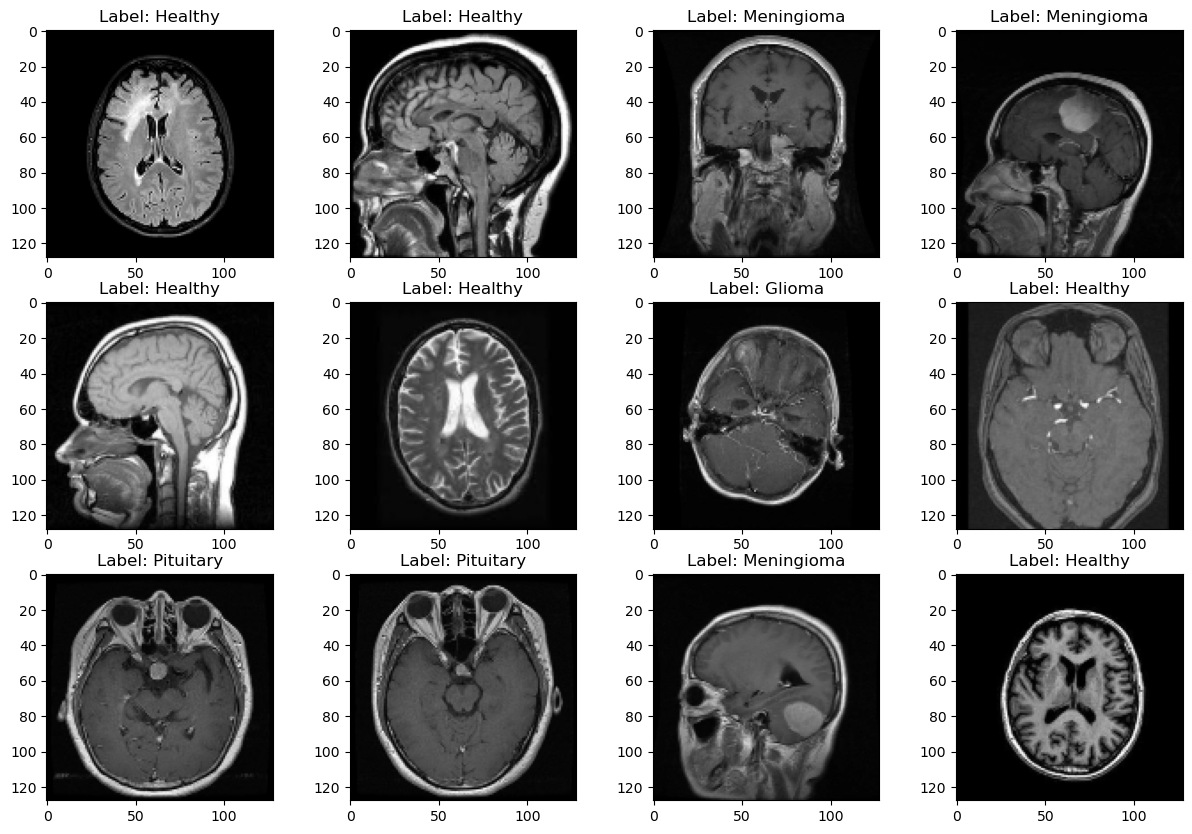

In [80]:
# Source: Code re-use from Lab 2 and 5

import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 10))
label_dict = {0: "Glioma", 1: "Meningioma", 2: "Healthy", 3: "Pituitary"}
# Iterate through the dataset
for i, (images, labels) in enumerate(ds_train.take(12)):
    plt.subplot(3,4,i+1)
    # Display the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {label_dict.get(np.argmax(labels))}")
        
plt.show()

### Metrics

I fully expect this to be a very challenging dataset. Just looking at these images you have different orientations which will challenge the ability to reliably detect edges and locations. Where there are positive tumor detection, it is difficult to visually see the difference in what those types of tumors are. 

To think about this in greater detail, I'll discuss what I believe the business case of a model like this would be. Unlike my previous breast cancer dataset in lab 5, this model is not focused on the lethality of the cancer. This model should be able to relieve the burden on radiologists by identifying patients with tumors. A study in Applied Radiology in 2015 indicated that radiologists need to interpret one image every 3-4 seconds in an eight hour workday (https://appliedradiology.com/articles/the-radiologist-s-gerbil-wheel-interpreting-images-every-3-4-seconds-eight-hours-a-day-at-mayo-clinic#:~:text=That%20is%20what%20radiologists%20interpreting,seconds%20to%20meet%20workload%20demands). Some of these images which are displayed above allow for an easy visual assessment of whether a tumor is present, many do not. So the intent of my model from a business case perspective, is to identify that a tumor is present, which can create a subset of patients for further detailed evaluation. This could help alleviate the burden on radiologists and identifying the specific class is simply added benefit.

With this in mind, now my concern becomes more focused on accidentally declaring a person with a tumor to be healthy, a false negative. So I'd prefer a metric that encourages more false positives so that only when confidence is very high that a patient is healthy, it doesn't receive a more detailed review. The metric that most closely aligns with this desire is recall, as it emphasizes performance of the model with respect to the true positive rate. 

#### Data Split

This dataset came pre-split in training and testing divisions. The total count of each is 2,870 training samples and 394 testing samples. I'd like to learn more about the existing data split to see if I believe it is sufficient for my purposes.

The number of Glioma tumors in the training data is 826
The number of Meningioma tumors in the training data is 822
The number of Healthy scans in the training data is 395
The number of Pituitary tumors in the training data is 827

The number of Glioma tumors in the testing data is 100
The number of Meningioma tumors in the testing data is 115
The number of Healthy scans in the testing data is 105
The number of Pituitary tumors in the testing data is 74


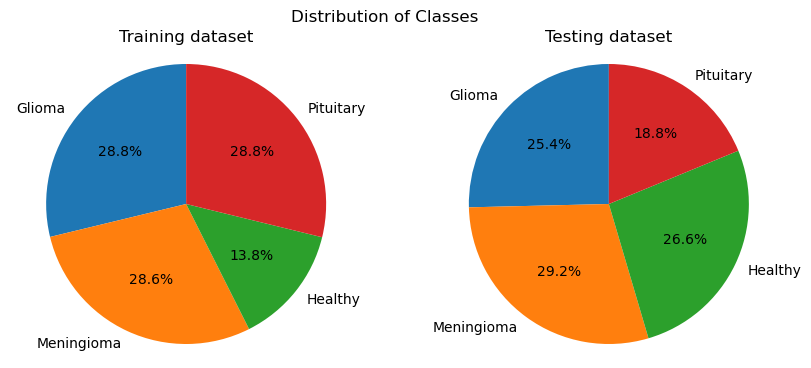

In [81]:
train_cancer_type = []
test_cancer_type = []
class_names = ["Glioma", "Meningioma", "Healthy", "Pituitary"]

batches_train = [label.numpy().astype(int) for (image,label) in ds_train] # get training batches
batches_test = [label.numpy().astype(int) for (image,label) in ds_test] # get testing batches

# Get the individual cancer types from each dataset
for train_batch in batches_train:
    for train_label in train_batch:
        train_cancer_type.append(np.argmax(train_label))

for test_batch in batches_test:
    for test_label in test_batch:
        test_cancer_type.append(np.argmax(test_label))

print(f"The number of Glioma tumors in the training data is {train_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the training data is {train_cancer_type.count(1)}")
print(f"The number of Healthy scans in the training data is {train_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the training data is {train_cancer_type.count(3)}\n")

print(f"The number of Glioma tumors in the testing data is {test_cancer_type.count(0)}")
print(f"The number of Meningioma tumors in the testing data is {test_cancer_type.count(1)}")
print(f"The number of Healthy scans in the testing data is {test_cancer_type.count(2)}")
print(f"The number of Pituitary tumors in the testing data is {test_cancer_type.count(3)}")

# Plot the data usig a pie plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pie_data = [train_cancer_type.count(0), train_cancer_type.count(1), train_cancer_type.count(2), train_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Training dataset')

plt.subplot(1,2,2)
pie_data = [test_cancer_type.count(0), test_cancer_type.count(1), test_cancer_type.count(2), test_cancer_type.count(3)]
plt.pie(pie_data, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Testing dataset')

plt.suptitle('Distribution of Classes')

plt.show()

From the above chart I can see that there are more healthy samples in the testing dataset and fewer pituitary tumors. Also, my test/train split is roughly 88/12.

One question I might want to ask myself when it comes to trying to create a brain tumor classification model is whether these breakouts are representative of what is normally found in real patients. I've researched commonality of types of tumors to make this comparison (source: https://www.hopkinsmedicine.org/health/conditions-and-diseases/brain-tumor/brain-tumor-types)
 -  Meningioma is the most common type of brain tumor, it is found in more than 30% of the cases
 -  Gliomas are also common and found in about 33% of cases
 -  Pituitary tumors fall into several types and make up roughly 10% of diagnosed cases

This distribution of values seems appropriate for the following reasons. 
 -  I'm not seeing a gross underrepresentation of one particular class 
 -  The alignment of Meningioma and Glioma seem particularly accurate for what is seen in practice
 -  The training samples for pituitary tumors is higher than seen in practice, but the test sample distribution is better aligned with what is seen in practice 

Because this data seems appropriately representative I don't intend to change the training and testing split or rebalance the categories.

## Modeling

In [82]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from copy import copy

For the first model, I need to provide a data augmentation technique. In order to better understand the impact of such additions, I'd like to visualize some of the results of their application. 

C:\Users\Chip\AppData\Local\Temp\ipykernel_7772\1494655463.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


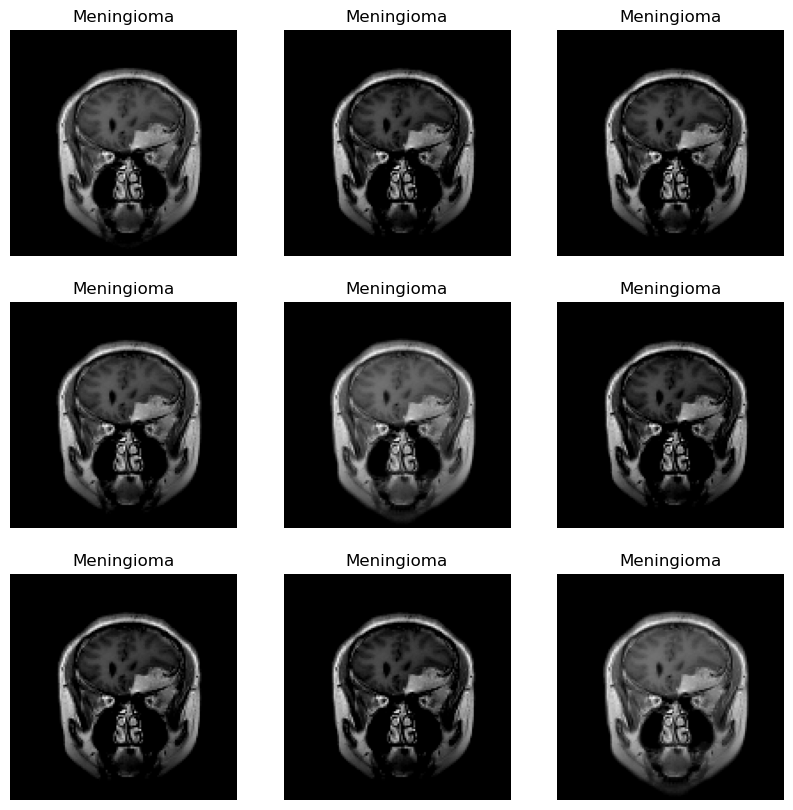

In [83]:
# Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# from tensorflow.keras.layers import RandomContrast, RandomBrightness

img_augmentation = Sequential(
    [
        layers.RandomBrightness(factor=(-0.3,0)),
        layers.RandomContrast(factor=0.2)
    ],
    name="img_augmentation",
)

plt.subplots(figsize=(10, 10))
for i, (images, labels) in enumerate(ds_train.take(1)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(images[0], axis=0))
        plt.imshow(aug_img.numpy().squeeze(), cmap='gray')
        # plt.imshow(images[0].numpy().squeeze(), cmap='gray')
        plt.title(f"{label_dict.get(np.argmax(labels))}")
        plt.axis("off")

Here, I'm focusing on brightness and contrast. Based on a review of the images in the dataset, many times the tumor indications show up very brightly. My hope is that by adjusting the contrast and the brightness I can further emphasize deliniations between healthy tissue and tumors.

Most of the images in the dataset are relatively bright. Therefore I selected a range (min,max) values which would darken the images. This Should improve performance because brigheter artifacts like the tumors and skull aren't as severely affected by dimming the image. Conversely, normal brain tissue which typically shows up in varrying shades of gray on the scans, will be significantly darkened. I anticipate that this will allow the model to identify edges more clearly which could help with diagnosis.

I also experimented with contrast, but found the results to be somewhat minimal visually no matter the factor used. So I'm using a random implementation her for that value. I did not initially implement a rotational or translation change to the images because based on my review of a random sample there are varrying orientations from which the scans were taken, axial, sagittal, and coronal. 

Below, I'll implement a comparison technique used in class. I'm modifying it to change the metric to recall which I will micro-average across the classes. I'm using micro-average because I have classes that are not completely equal, so I want to look at my recall score at an instnace level instead of at the overarching class level (https://www.evidentlyai.com/classification-metrics/multi-class-metrics#:~:text=In%20a%20simple%20case%2C%20you,equal%20weight%20to%20each%20instance.) The imbalance of my classes is probably not so extreme that macro averaging wouldn't give me similar results.

In [84]:
# Source: modified from in class lecture
# I'll use this function repeatedly throughout the lab
from sklearn import metrics as mt
from matplotlib import pyplot as plt
# from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, ds_test, title_text=''):
    plt.figure(figsize=(15,5))
    # convert dataset to test set we can use with sklearn.metrics
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    yhat = np.argmax(net.predict(ds_test), axis=1)
    # acc = mt.accuracy_score(y_test,yhat.squeeze())
    acc = mt.recall_score(y_test,yhat.squeeze(),average='micro') # want to focus on recall, micro-average
    cm = mt.confusion_matrix(y_test,yhat.squeeze())
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names,yticklabels=class_names)
    plt.title(f'{title_text} {acc:.4f}')
    

#### Architecture 1 - Model 1 
I'm reusing a model from lecture for this first architecture. I've modified it by bringing in the data augmentation values as the first two layers. These are followed by a convolutional layer with a 3x3 kernel size and 32 filters, then by another convolutional layer with a 3x3 filter and 64 filters. Finally, a pooling layer with size 2, 2 is applied. Then the data is flattened for the MLP portion of the model with 64 neurons with Relu and an ouput layer of 4 classes with a softmax activation.

My loss function will be Categorical Cross-entroy and as discussed above, my metric will be focused on Recall. My optimizer is rmsprop.

In [85]:
%%time
# Source: Modified from notebook 12a

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

NUM_CLASSES = 4
arch1_cnn1 = Sequential()

# add in augmentations directly
arch1_cnn1.add( RandomBrightness(factor=(-0.3,0)) )
arch1_cnn1.add( RandomContrast(factor=0.2) )

# let's start with an AlexNet style convolutional phase
arch1_cnn1.add(Conv2D(filters=32,
                input_shape = (128,128),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
arch1_cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
                
arch1_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
arch1_cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
arch1_cnn1.add(Flatten())
arch1_cnn1.add(Dense(64, activation='relu'))
arch1_cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
arch1_cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
arch1_cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

arch1_cnn1.build((None,128,128,1))

arch1_cnn1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_15 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_15 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [86]:
%%time 
history_arch1_cnn1 = arch1_cnn1.fit(
        ds_train,
        batch_size=64,
        epochs=30,
        verbose=1,
        validation_data=ds_test
        )

Epoch 1/30
45/45 [==============================] - 78s 2s/step - loss: 53.1107 - recall: 0.2798 - val_loss: 1.3443 - val_recall: 0.0482
Epoch 2/30
45/45 [==============================] - 84s 2s/step - loss: 1.2187 - recall: 0.2481 - val_loss: 2.5585 - val_recall: 0.2411
Epoch 3/30
45/45 [==============================] - 95s 2s/step - loss: 1.0104 - recall: 0.4188 - val_loss: 1.4286 - val_recall: 0.1396
Epoch 4/30
45/45 [==============================] - 95s 2s/step - loss: 0.7937 - recall: 0.5693 - val_loss: 1.7633 - val_recall: 0.3020
Epoch 5/30
45/45 [==============================] - 91s 2s/step - loss: 0.6561 - recall: 0.6840 - val_loss: 1.7329 - val_recall: 0.3350
Epoch 6/30
45/45 [==============================] - 89s 2s/step - loss: 0.5277 - recall: 0.7693 - val_loss: 1.7046 - val_recall: 0.4848
Epoch 7/30
45/45 [==============================] - 89s 2s/step - loss: 0.3821 - recall: 0.8362 - val_loss: 4.9365 - val_recall: 0.4594
Epoch 8/30
45/45 [=============================

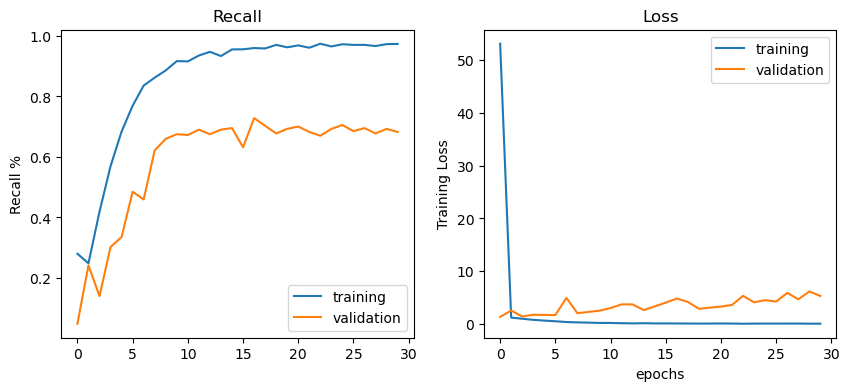

In [87]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch1_cnn1.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch1_cnn1.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch1_cnn1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch1_cnn1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
#plt.show()

With architecture 1 model 1 I'm not seeing my loss function on the validation data converging. The continuous rise in the loss function on test data indicates I'm probably overfitting the training data. With this model trained I can employ the previous function to create the confusion matrix. 

7/7 [==============================] - 2s 275ms/step


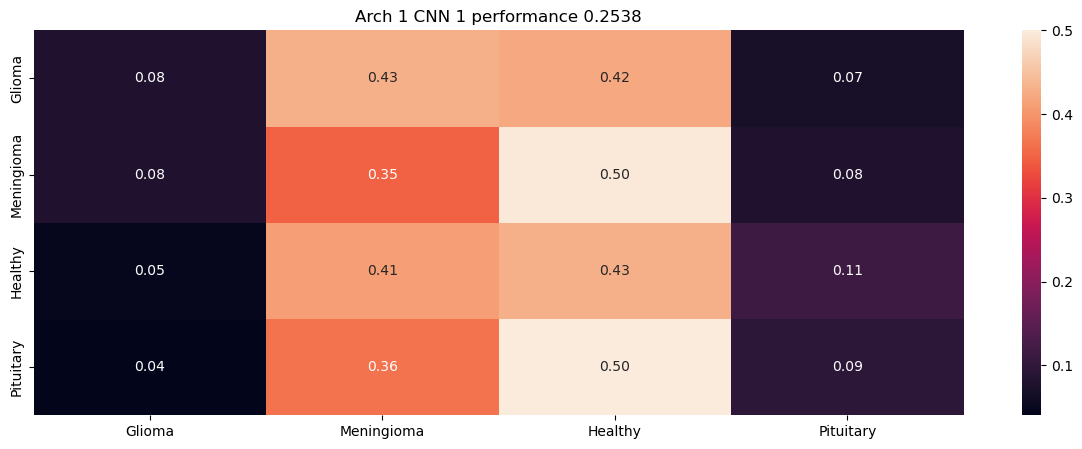

In [88]:
summarize_net(arch1_cnn1, ds_test, title_text='Arch 1 CNN 1 performance')

With my confusion matrix I'm looking at the actual classes across the bottom and the predictions across up and down the left side. So I'm seeing the Glioma and Pituitary tumors are rarely being identified correctly. When the case is actually a Meningioma tumor, it is being categorized somewhat evenly across the 4 categories. Actually healthy scans seem to catch the majority of the predictions. 

When it comes to my business case, I chose recall because I didn't want situations in which a lot of healthy predictions are actually tumors. So looking across the data in the Healthy row I'm seeing that this looks good for Glioma and Pituitary tumors, however I have a large number of cases of Meningioma tumors predicted as healthy which is very bad for patient outcome. Further, when the scans are actually healthy I'm predicting a fairly even distribution of various tumors and healthy scans. While I'm encouraged by the amount of healthy scans it gets right, this isn't helping my business case of trying to relieve burden on radiologists because more healthy scans are being predicted as tumors.

#### Architecture 1 - Model 2

In the second model of architecture 1 I'm going to add some regulization to the dense layer to hopefully reduce what seems to be an overfitting problem as seen in my loss function on the validation data. Also, I have changed the optimizer to adam.

In [126]:
%%time
# Source: Modified from notebook 12a
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.layers import BatchNormalization
l2_lambda = 0.016

# NUM_CLASSES = 4
arch1_cnn2 = Sequential()

# add in augmentations directly
arch1_cnn2.add( RandomBrightness(factor=(-0.3,0)) )
arch1_cnn2.add( RandomContrast(factor=0.2) )

# let's start with an AlexNet style convolutional phase
arch1_cnn2.add(Conv2D(filters=32,
                input_shape = (128,128),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
arch1_cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
                
arch1_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
arch1_cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
arch1_cnn2.add(Flatten())
arch1_cnn2.add(Dense(64, activation='relu',kernel_regularizer=l2(l2_lambda)))
arch1_cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
arch1_cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
arch1_cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

arch1_cnn2.build((None,128,128,1))

arch1_cnn2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_20 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_20 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [127]:
%%time 
history_arch1_cnn2 = arch1_cnn2.fit(
        ds_train,
        batch_size=64,
        epochs=30,
        verbose=1,
        validation_data=ds_test
        )

Epoch 1/30
45/45 [==============================] - 204s 4s/step - loss: 27.4725 - recall: 0.1491 - val_loss: 7.2683 - val_recall: 0.0279
Epoch 2/30
45/45 [==============================] - 193s 4s/step - loss: 5.6898 - recall: 0.2512 - val_loss: 7.2349 - val_recall: 0.1853
Epoch 3/30
45/45 [==============================] - 190s 4s/step - loss: 4.3873 - recall: 0.5017 - val_loss: 6.5818 - val_recall: 0.3325
Epoch 4/30
45/45 [==============================] - 199s 4s/step - loss: 3.6312 - recall: 0.6272 - val_loss: 5.1821 - val_recall: 0.4746
Epoch 5/30
45/45 [==============================] - 186s 4s/step - loss: 3.0294 - recall: 0.7174 - val_loss: 5.8529 - val_recall: 0.4721
Epoch 6/30
45/45 [==============================] - 173s 4s/step - loss: 2.7165 - recall: 0.7383 - val_loss: 5.2830 - val_recall: 0.4975
Epoch 7/30
45/45 [==============================] - 455s 10s/step - loss: 2.3951 - recall: 0.7794 - val_loss: 4.8333 - val_recall: 0.5558
Epoch 8/30
45/45 [=====================

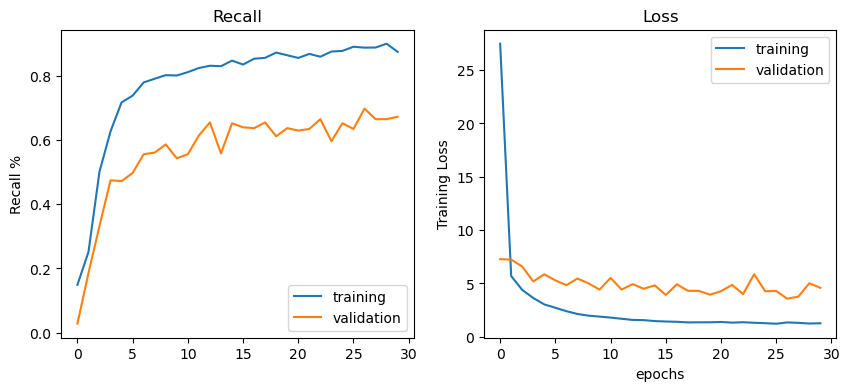

In [128]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch1_cnn2.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch1_cnn2.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch1_cnn2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch1_cnn2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
#plt.show()

7/7 [==============================] - 5s 561ms/step


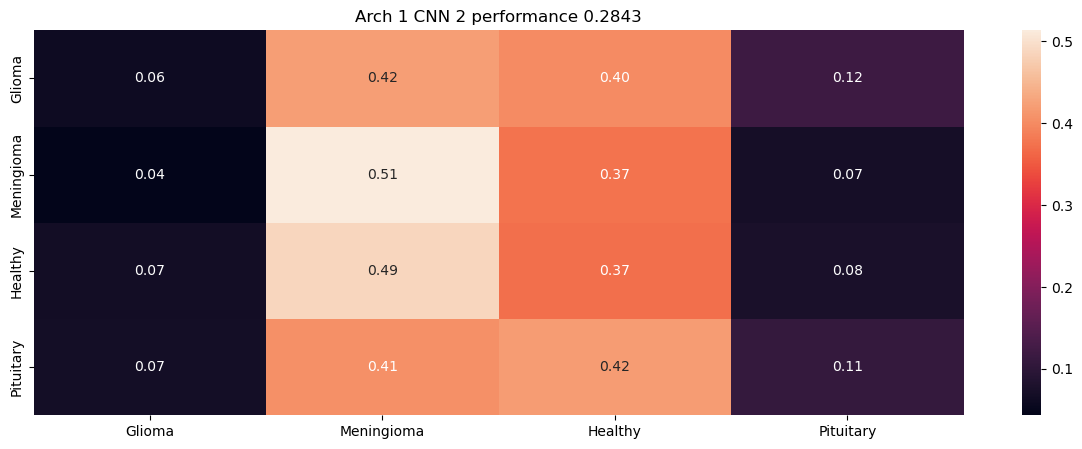

In [129]:
summarize_net(arch1_cnn2, ds_test, title_text='Arch 1 CNN 2 performance')

The added regularization appears to have helped with my loss function on the validation data. Its now descending and appears to get to a point of convergence. The overall values this function converges around appear to be better too.

The confusion matrix generally looks unchanged from model 1.

#### Architecture 2 - Model 1

In the architecture below, I've added two dense layers in the ML portion to provide a smoother step down to my 4 classification groups. I've kept the optimizer and loss function the same as in my first model, as well as keeping the l2 regularization with each dense layer.

In [93]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

arch2_cnn1 = Sequential()

# add in augmentations directly
arch2_cnn1.add( RandomBrightness(factor=(-0.3,0)) )
arch2_cnn1.add( RandomContrast(factor=0.2) )
# arch2_cnn1.add( RandomRotation(factor=0.15) )

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    arch2_cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    arch2_cnn1.add( MaxPooling2D(pool_size=(2, 2) ) )
    

# add one layer on flattened output
arch2_cnn1.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
arch2_cnn1.add( Flatten() )
arch2_cnn1.add( Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)) ) # added kernel_regularizer
arch2_cnn1.add( Dropout(0.5) ) # add some dropout for regularization, again!
arch2_cnn1.add( Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)) ) # added by me
arch2_cnn1.add( Dense(16, activation='relu', kernel_regularizer=l2(l2_lambda)) ) # added by me
arch2_cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
arch2_cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

input_shape = [None, 128,128,1]
arch2_cnn1.build(input_shape)
print(arch2_cnn1.summary())

history_arch2_cnn1 = arch2_cnn1.fit(ds_train,
            batch_size=64, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(ds_test))



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_17 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_17 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                     

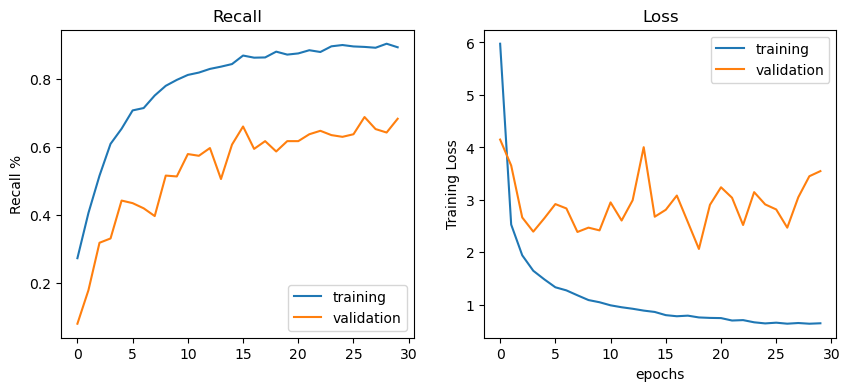

In [94]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch2_cnn1.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch2_cnn1.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch2_cnn1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch2_cnn1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

My loss function on my training data takes a little longer to reach what appears to be convergence. The loss function on the validation data remains relatively flat on average. While that's still not exactly what we're looking for, the overall values are lower.

7/7 [==============================] - 1s 117ms/step


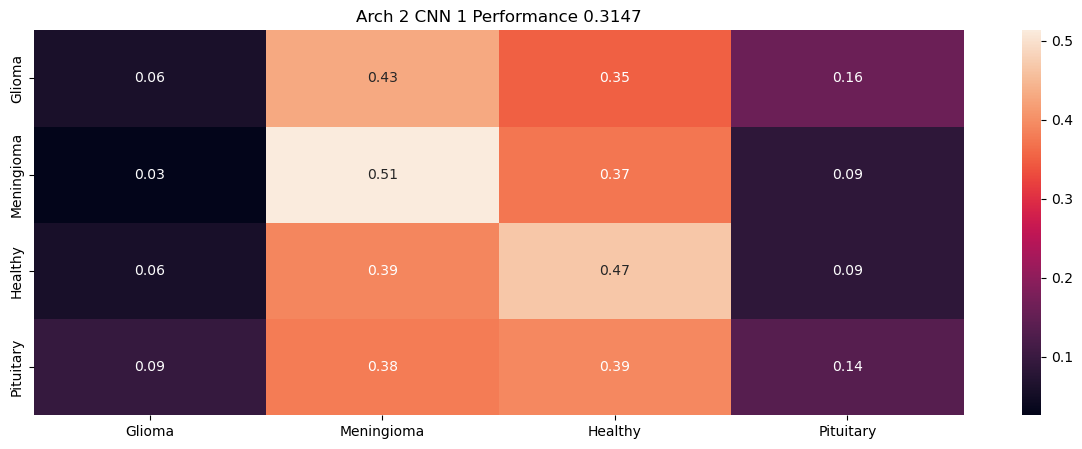

In [95]:
summarize_net(arch2_cnn1, ds_test, title_text='Arch 2 CNN 1 Performance')

The confusion matrix looks relatively the same as previous runs with the majority of the predictions falling into the Meningioma or Healthy classifications.

#### Architecture 2 - Model 2

For model 2 of architecture 2 I have added in a RandomRotation component as part of the data augmentation. I've also changed the optimizer to Adam.

In [97]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

arch2_cnn2 = Sequential()

# add in augmentations directly
arch2_cnn2.add( RandomBrightness(factor=(-0.3,0)) )
arch2_cnn2.add( RandomContrast(factor=0.2) )
arch2_cnn2.add( RandomRotation(factor=0.15) )

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    arch2_cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    arch2_cnn2.add( MaxPooling2D(pool_size=(2, 2) ) )

# add one layer on flattened output
arch2_cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
arch2_cnn2.add( Flatten() )
arch2_cnn2.add( Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)) )
arch2_cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
arch2_cnn2.add( Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)) ) # added by me
arch2_cnn2.add( Dense(16, activation='relu', kernel_regularizer=l2(l2_lambda)) ) # added by me
arch2_cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
arch2_cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adam', # 'adadelta' 'rmsprop'
              metrics=['Recall'])

input_shape = [None, 128,128,1]
arch2_cnn2.build(input_shape)
print(arch2_cnn2.summary())

history_arch2_cnn2 = arch2_cnn2.fit(ds_train,
            batch_size=64, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(ds_test))



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_19 (Rando  (None, 128, 128, 1)      0         
 mBrightness)                                                    
                                                                 
 random_contrast_19 (RandomC  (None, 128, 128, 1)      0         
 ontrast)                                                        
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 1)      0         
 tion)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                

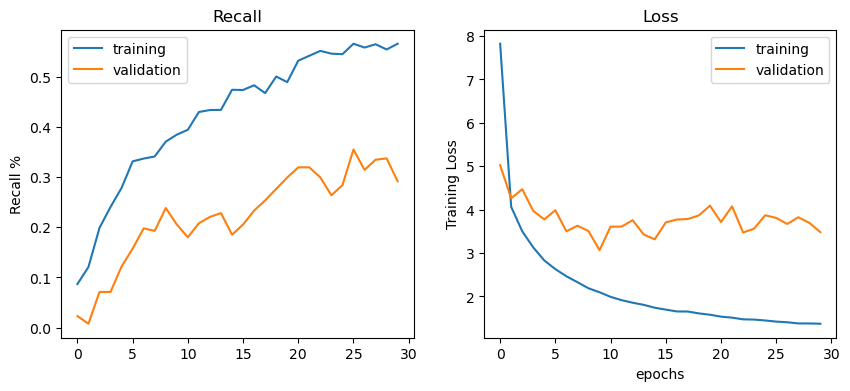

In [98]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_arch2_cnn2.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history_arch2_cnn2.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_arch2_cnn2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_arch2_cnn2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

It appears the rotation may have helped with some of the overfitting issues. I'm seeing a return to a descent of the loss function on the validation data which is desirable. However, the recall score on both training and validation data is worse than previous models. This is one that probably could have benefitted from more epochs.

7/7 [==============================] - 1s 123ms/step


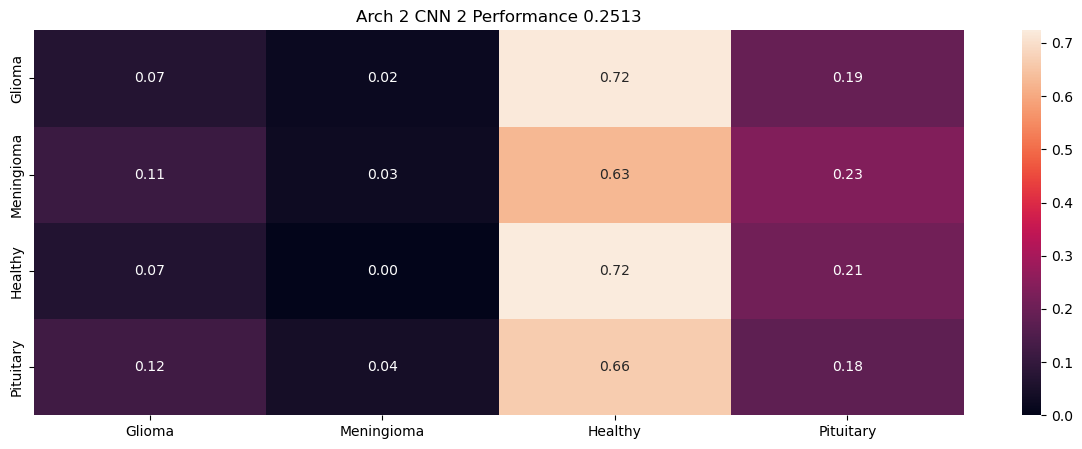

In [99]:
summarize_net(arch2_cnn2, ds_test, title_text='Arch 2 CNN 2 Performance')

This is an interesting result from the confusion matrix perspective and looks quite different than my other matrices. Now it looks like the majority of my predictions for each classification are being applied to actually healthy values. 
 -  72% of the time it predicts Glioma it is actually healthy
 -  63% of the time it predicts Meningioma it is actually healthy
 -  72% of the healthy predictions are correct
 -  66% of the Pituitary predictions are actually healthy

I am also seeing increased prediction of various tumors in actual pituitary cases which wasn't seen with other models. These results are good from the perspective that the model is being overly cautious in identifying tumors with so many predictions of various tumors in actual healthy images. However this again doesn't help the business case of deceasing radiologist workload. I'm curious if these confusion matrix results indicate some sort of error was present when I trained this model. 

#### Comparison of the Four Models

I'll start my model comparison by lookiing at the confusion matricies across all 4.

In [147]:
# Source: Modified from in class lecture to compare CNNs
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_cnn(cnn_1, cnn_2, cnn_3, cnn_4, X_test, y_test, labels='auto'):
    plt.figure(figsize=(12,8))
    y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)
    y_test = y_test.numpy()
    
    # yhat = np.argmax(net.predict(ds_test), axis=1)
    models_to_compare = [cnn_1, cnn_2, cnn_3, cnn_4]
    model_names = ["Architecture 1 - Model 1",
                   "Architecture 1 - Model 2",
                   "Architecture 2 - Model 1",
                   "Architecture 2 - Model 2"]
    i=1 # use as iterator
    for model in models_to_compare:
        yhat_cnn = np.argmax(model.predict(X_test), axis=1)
        acc = mt.recall_score(y_test,yhat_cnn.squeeze(),average='micro')
        plt.subplot(2,2,i)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'{model_names[i-1]}: {acc:.4f}')
        i+=1
        
        
    # print(mt.classification_report(y_test,yhat_cnn))



    plt.show()
    

7/7 [==============================] - 2s 240ms/step


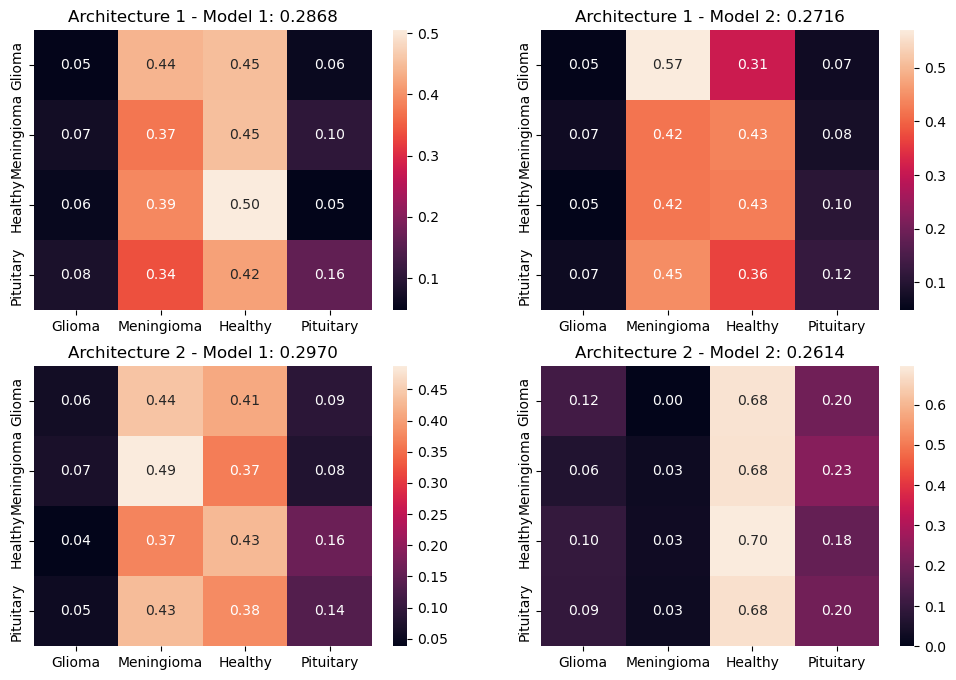

In [148]:
compare_cnn(arch1_cnn1,
            arch1_cnn2,
            arch2_cnn1,
            arch2_cnn2,
            ds_test,
            ds_test,
            class_names
            )

After running the compare_cnn function on all 4 models created, I see results that largely align with the results I presented for the individual models. I'm not sure I completely understand why the stated Recall value (top of each matrix) is so low when in most models the val_Recall values typically ended in the 60% range at the end of the epoch range. However, based on what is shown above on the test data, it appears that Architecture 2, Model 1 is my best performer. 

Next, I'll perform a statistical comparison to determine if there are really true differences between the models that share architecture. 

In [216]:
### Architecture 1 ###
# Modeified from lab 5 and in-class lecture to use recall
from scipy.stats import t

# Get the histories of recall scores from my two models for comparison
recall_arch1_mod1 = history_arch1_cnn1.history['val_recall']
recall_arch1_mod2 = history_arch1_cnn2.history['val_recall']

# get error rates for both model's recall scores
arch_1_mod1_err = [1 - rc for rc in recall_arch1_mod1]
arch_1_mod2_err = [1 - rc for rc in recall_arch1_mod2]

d = []
for err in range(len(arch_1_mod1_err)):
    d.append(arch_1_mod1_err[err] - arch_1_mod2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 30
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the first architecture')

Range of: -0.18622361854335293 0.1364774364791376 between the two models in the first architecture


This interval does not contain 0. So with 95% confidence I can say there is some statistical difference between the first two models sharing the same architecture. Because of this, I can say that Arch 1 Model 1 is the better performer of the two.

Next I'll perform the same for the two models from the second architecture and then an overall comparison.

In [217]:
### Architecture 2 ###
# Modeified from lab 5 and in-class lecture to use recall
# from scipy.stats import t

# Get the histories of recall scores from my two models for comparison
recall_arch2_mod1 = history_arch2_cnn1.history['val_recall']
recall_arch2_mod2 = history_arch2_cnn2.history['val_recall']

# get error rates for both model's recall scores
arch_2_mod1_err = [1 - rc for rc in recall_arch2_mod1]
arch_2_mod2_err = [1 - rc for rc in recall_arch2_mod2]

d = []
for err in range(len(arch_2_mod1_err)):
    d.append(arch_2_mod1_err[err] - arch_2_mod2_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the second architecture')

Range of: -0.47132320762968793 -0.15016579089018967 between the two models in the second architecture


Using the same confidence interval (95%) there is statistical difference between these two models as well as the given range does not contain 0. 

Looking back at how the models performed:
 - Recall score of ~0.3 for Arch 2 Model 1 
 - Recall score of ~0.26 for Arch 2 Model 2. 
 
Therefore I can say conclusively that architecture 2 model 1 is different, and performs better than model 2 from the same architecture.

Now I'll compare architecture 2 model 1 with the best performer from architecture 1, which was model 1. 

In [218]:
# Modeified from lab 5 and in-class lecture to use recall
# Compare Arch 1 model 2 with arch 2 model 1
from scipy.stats import t

d = []
for err in range(len(arch_1_mod1_err)):
    d.append(arch_1_mod1_err[err] - arch_2_mod1_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 30
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the second architecture')

Range of: -0.21965567262757735 0.10713452465125833 between the two models in the second architecture


Here, I also see a range that does not include 0 indicating that these two models are statistically different from one another, with 95% confidence. Therefore looking back at performance meausres with respect to recall:
 -  Arch 1 Mod 1 Recall = 0.2868
 -  Arch 2 Mod 1 Recall = 0.2970

I can conclusively say that Architecture 2 Model 1 is my best performing model from the perspective of recall.

#### Best Model vs MLP with ROC Curve

I'll start by making a simple multi-layered perceptron model using my test and train data and seeing how it performs.

In [224]:
%%time
# Source: Modified from in-class lecture notebook 11
# CREATE A BASELINE MLP WITH THREE LAYERS

# since this is not binary, we should go ahead and one-hot encode the inputs
# y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
# y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['Recall'])

mlp_history = mlp.fit(ds_train, 
        batch_size=64, epochs=30, 
        shuffle=True, verbose=1,
        validation_data=(ds_test))

Epoch 1/30
45/45 [==============================] - 3s 39ms/step - loss: 48.0655 - recall: 0.4174 - val_loss: 25.9506 - val_recall: 0.3629
Epoch 2/30
45/45 [==============================] - 2s 35ms/step - loss: 6.9153 - recall: 0.6052 - val_loss: 27.4799 - val_recall: 0.4061
Epoch 3/30
45/45 [==============================] - 2s 33ms/step - loss: 5.9874 - recall: 0.6268 - val_loss: 32.4999 - val_recall: 0.4086
Epoch 4/30
45/45 [==============================] - 2s 35ms/step - loss: 2.9693 - recall: 0.7530 - val_loss: 26.6043 - val_recall: 0.4975
Epoch 5/30
45/45 [==============================] - 2s 37ms/step - loss: 5.5668 - recall: 0.6571 - val_loss: 31.2747 - val_recall: 0.4188
Epoch 6/30
45/45 [==============================] - 2s 34ms/step - loss: 3.8544 - recall: 0.7404 - val_loss: 26.0701 - val_recall: 0.5152
Epoch 7/30
45/45 [==============================] - 2s 34ms/step - loss: 2.4445 - recall: 0.7857 - val_loss: 24.8319 - val_recall: 0.6142
Epoch 8/30
45/45 [===============

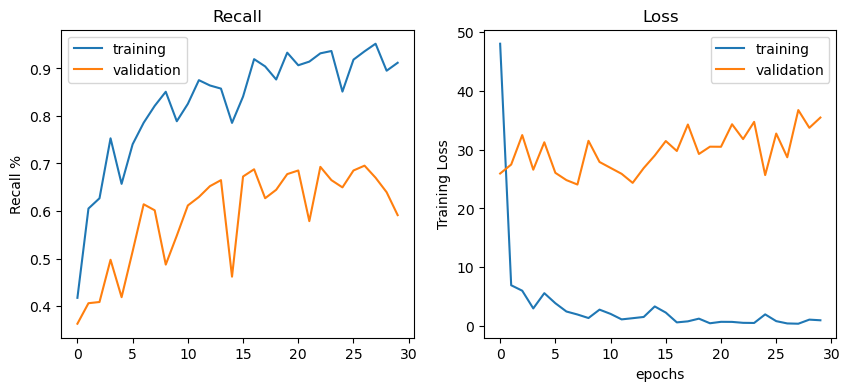

In [225]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mlp_history.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(mlp_history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(mlp_history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

These results largely mirror my expectation. The Loss function does not converge on the validation data at all, indicating I probably have some overfitting going on. I do see surprisingly higher results on recall than I would have expected, but they are very inconsistent. There's a possibility with more epochs this model would perform slightly better. But there would need to be some other adjustments like regularization and dropout to help combat the overfitting.

Note, I tried to get OvR ROC curves functioning to compare the AUC for the MLP and my best model but kept getting stuck and was unable to figure out how to complete. Below is the code I attempted. What I can say about the results from each epoch is that I'm seeing little better performance than pure chance with the multi-layer perceptron alone. I would have expected this performance given the complexity of the images which likely require far more sophisticated means of analysis to train a model sufficiently for prediction.

In [196]:
# Source: Modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay

X_train = tf.concat([tf.argmax(x,axis=1) for x, y in ds_train], axis=0) # added this line
X_test = tf.concat([tf.argmax(x,axis=1) for x, y in ds_test], axis=0) # added this line
y_train = tf.concat([tf.argmax(y,axis=1) for x, y in ds_train], axis=0)
y_test = tf.concat([tf.argmax(y,axis=1) for x, y in ds_test], axis=0)

y_score = np.argmax(arch2_cnn1.predict(X_test), axis=1)

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()


ValueError: in user code:

    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\Chip\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'max_pooling2d_13' (type MaxPooling2D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_13/max_pooling2d_13/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_13/conv2d_22/Relu)' with input shapes: [?,128,1,32].
    
    Call arguments received by layer 'max_pooling2d_13' (type MaxPooling2D):
      • inputs=tf.Tensor(shape=(None, 128, 1, 32), dtype=float32)


I'll compare my MLP to my best CNN using the same statistical methods employed above.

In [226]:
### Architecture 1 ###
# Modeified from lab 5 and in-class lecture to use recall
# from scipy.stats import t

# Get the histories of recall scores from my two models for comparison
recall_mlp = mlp_history.history['val_recall']
recall_arch2_mod1 = history_arch2_cnn1.history['val_recall']

# get error rates for both model's recall scores
mlp_err = [1 - rc for rc in recall_mlp]

d = []
for err in range(len(arch_2_mod1_err)):
    d.append(arch_2_mod1_err[err] - mlp_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

# epochs = 30
# confidence_level = 0.95
# degrees_of_freedom = epochs

# Calculate the critical value, t
# t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the first architecture')

Range of: -0.1301557044916389 0.24487652587225414 between the two models in the first architecture


These results are telling me that with 95% confidence I can say there is no statistical difference between this model and architecture 2 model 1 because the range given above contains 0.

## Transfer Learning

To understand where the industry standard is with respect to tumor classification from medical imaging I reviewed a paper from the National Library of Medicine (Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9854739/#:~:text=The%20second%20CNN%20architecture%20can,Grade%20III%2C%20and%20Grade%20IV). There have been many implmenetations of existing CNNs combined with tuning of hyperparameters that have in many cases gotten the accuracy on datasets like this to over 95%. 

Below I'll try to run EfficientNet on my dataset to compare results (source: https://medium.com/mlearning-ai/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad). I need to be careful to select a model that my computer can handle. Efficient Net is a good pairing for this concern as it provides "just enough" scaling based on the inputs. As a side note I tried to get a GPU enabled version of tensorflow running on my desktop computer but ran into more issues than it was worth pursuing. So I'm sticking to my Surface Pro 8 which is a pretty blunt instrument for this task.

In [118]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [119]:
# Source: All code in this section is modified from
# https://www.kaggle.com/code/shivansh2503/tumor-classification-96-train-accuracy

base_model=tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3), # Modified input image size
    pooling='max',
    classifier_activation="softmax",
)

for layer in base_model.layers:
    layer.trainable = False # don't update weights of pre-trained layers
    
model=Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.016),
    Dense(512,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(64,kernel_regularizer=regularizers.l2(l= 0.016), activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')    
])

In [120]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Recall'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_47 (Dense)            (None, 512)               786944    
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                32832     
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                     

In [121]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_recall",
    mode = "max",
    save_best_only = True
)

In [122]:
history = model.fit(ds_train,
                    epochs = 100,
                    validation_data = ds_test,
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/100
45/45 [==============================] - 70s 1s/step - loss: 11.6785 - recall: 0.6436 - val_loss: 8.6450 - val_recall: 0.4695
Epoch 2/100
45/45 [==============================] - 61s 1s/step - loss: 5.6666 - recall: 0.7683 - val_loss: 4.2796 - val_recall: 0.5964
Epoch 3/100
45/45 [==============================] - 61s 1s/step - loss: 2.8072 - recall: 0.7923 - val_loss: 2.5659 - val_recall: 0.6523
Epoch 4/100
45/45 [==============================] - 62s 1s/step - loss: 1.6510 - recall: 0.8300 - val_loss: 2.0295 - val_recall: 0.5939
Epoch 5/100
45/45 [==============================] - 65s 1s/step - loss: 1.2356 - recall: 0.8105 - val_loss: 1.6710 - val_recall: 0.6015
Epoch 6/100
45/45 [==============================] - 67s 1s/step - loss: 0.9831 - recall: 0.8366 - val_loss: 1.6849 - val_recall: 0.6421
Epoch 7/100
45/45 [==============================] - 67s 1s/step - loss: 0.8899 - recall: 0.8233 - val_loss: 1.6214 - val_recall: 0.6371
Epoch 8/100
45/45 [=====================

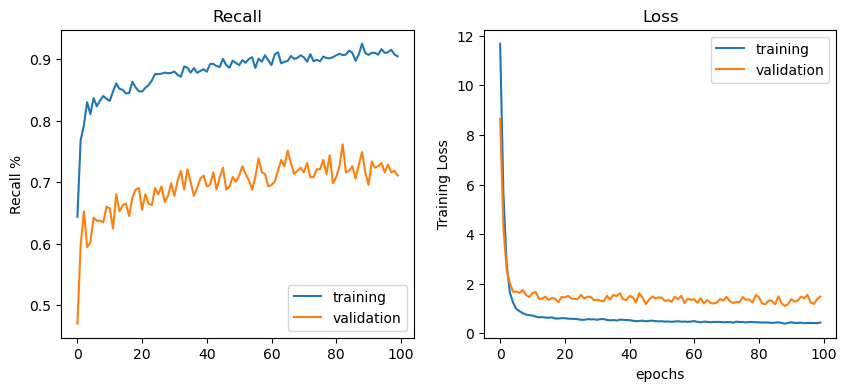

In [123]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['recall'], label='training')

plt.ylabel('Recall %')
plt.title('Training')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

These results alignm much better to what I would expect to see in training and testing a neural network. I'm seeing decrease in loss functions on both training and validation data which is good. They both approach a relatively flat level indicating convergence, also good. 

Over the 100 epochs this model trained for I can see that my recall score does go up further than my other models, hitting avove 70% for the validation data. 

7/7 [==============================] - 9s 960ms/step


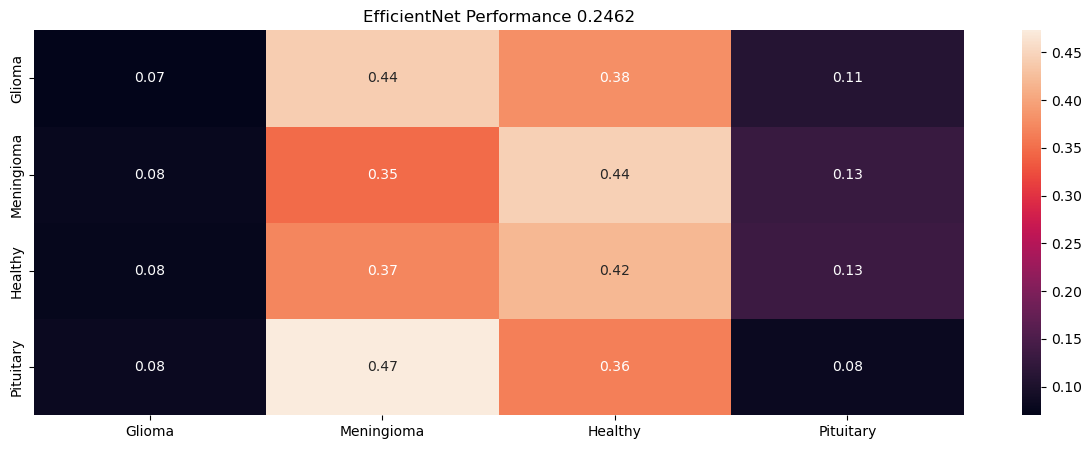

In [124]:
summarize_net(model, ds_test, title_text='EfficientNet Performance')

Even with better looking charts from a loss and Recall perspective I'm not seeing significant improvement of my cofusion matrix. In fact, this matrix looks much closer to the first 3 models than the 4th. Almost all predictions are landing in the category of Meningioma or Healthy.

In [219]:
# Modeified from lab 5 and in-class lecture to use recall
# Compare Arch 2 model 1 with EfficientNet
from scipy.stats import t

recall_model = history.history['val_recall']
model_err = [1 - rc for rc in recall_model]

d = []
for err in range(len(arch_2_mod1_err)):
    d.append(model_err[err] - arch_2_mod1_err[err])

dbar = sum(d) / len(d)
stdtot = np.std(d)

epochs = 30
confidence_level = 0.95
degrees_of_freedom = epochs

# Calculate the critical value, t
t = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# print(f'The error of the three models is\n', acc1.mean(), '\n', acc2.mean(), '\n', acc3.mean())
print('Range of:', dbar-t*stdtot,dbar+t*stdtot, 'between the two models in the second architecture')

Range of: -0.34805033529709734 0.11404017731458899 between the two models in the second architecture


With these results I can again say that with 95% confidence these models are different. If I were to rely on the values I'm seeing at the top of my confusion matrices I would have to conclude that arch 1 model 1 is the better performer. However given the complexities associated with EfficientNet which I know to be a far more sophisticated CNN than the one I developed, I highly question that conclusion. The likely reality here are that the values I'm seeing from the top of the confusion matrices and those seen in the recall curves with validation data are not the same thing. What I feel confident enought to say is that all of the statistical comparisons I performed showed that with 95% confidence my models are indeed different. This, compared with the results of the Recall curves aligning with my expectations leads me to believe the best performing model is the one using EfficientNet.

The question still remains as to whether the business case could be supported with this final model. I believe the simple answer is, no. This model likely needs a great deal of additional tweaks to get to a point where it would be acceptable to use. As previously stated, the business case of this effort was to identify tumors in the MRI scans such that Radiologists could focus their time there and alleviate the burden of having so many scans to review. From my final confusion matrix, I can see that my model is only predicting healthy scans that align with actual healthy scans about 42% of the time. More troubling is the fact that when the scan contains a Meningioma Tumor, my model is predicting it is healthy 37% of the time. This is far too many false negatives to be acceptable for my business case currently.